# Zeitfensteranalyse

## Einleitung

Ziel dieses Notebooks ist es eine Unterstützung zu bieten, um ein Zeitfenster zu bestimmen, in welchem Bewegungssensordaten    
zu einer Aufnahme erfasst werden. Zu diesen gehören die Beschleunigungssensordaten X,Y,Z sowie die Winkel Roll, Nick und Gier.   

## Herausforderungen

Bevor die Belichtung einer Aufnahme beginnt sollen bereits die Bewegungsdaten erfasst werden. Es gibt einen Handler in der Android   
Camera2 API, welcher beim Start der Belichtung aufgerufen wird. Wenn dann erst die Erfassung der Daten gestartet wird, dann    
wäre dies bereits zu spät. Da zu diesem Zeitpunkt die Belichtung bereits begonnen hat. Eine weitere Herausforderung ist ausreihend Datenwerte   
zu ermitteln. Ist die Datenerfassung zu kurz werden nur wenige bis keine Daten erfasst. Desweiteren ist der Zeitpunkt   
bei welchem die Datenerfassung gestoppt wird relevant.

In [1]:
import pandas
import pandas 
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import datetime

In [5]:
featuresDf = pandas.read_csv(filepath_or_buffer="../merkmale.csv")

In [6]:
featuresDf.describe()

,Zeitstempel,Breitengrad,Laengengrad,Geschwindigkeit,Messwerte,StartBewegungsD,StartBelichtung,Belichtungszeit,MittelX,MittelY,...,VarianzX,VarianzY,VarianzZ,VarianzNick,VarianzRoll,AbweichungX,AbweichungY,AbweichungZ,AbweichungNick,AbweichungRoll
count,1.214900e+04,12149.000000,12149.000000,12149.000000,12149.0,1.214900e+04,1.214900e+04,1.214900e+04,12149.000000,12149.000000,...,12149.000000,12149.000000,12149.000000,12149.000000,12149.000000,12149.000000,12149.00000,12149.000000,12149.000000,12149.000000
mean,1.520521e+12,53.621404,10.175575,15.419228,20.0,3.972071e+12,3.972161e+12,1.931440e+07,0.001482,0.003506,...,2.121109,16.710875,17.784782,0.176490,0.252438,1.200596,3.22775,3.402667,0.380466,0.323835
std,1.226303e+06,0.006939,0.018062,3.447197,0.0,1.226303e+12,1.226303e+12,8.842717e+06,0.279567,0.564297,...,4.805029,37.120677,34.064271,0.165855,0.595264,0.824460,2.50859,2.491415,0.178153,0.384162
min,1.520519e+12,53.610477,10.137807,5.004000,20.0,1.618455e+12,1.618559e+12,4.127597e+06,-2.285901,-4.989452,...,0.000370,0.000230,0.000380,0.000000,0.000010,0.019240,0.01517,0.019490,0.000000,0.003160
25%,1.520520e+12,53.614110,10.161995,13.608000,20.0,2.973751e+12,2.973839e+12,1.000184e+07,-0.141578,-0.247978,...,0.515670,3.221720,3.578670,0.059210,0.011630,0.718100,1.79492,1.891740,0.243330,0.107840
50%,1.520521e+12,53.621760,10.177186,15.804000,20.0,3.963729e+12,3.963809e+12,2.000368e+07,0.000789,-0.004989,...,0.937230,6.096390,6.850140,0.114540,0.025740,0.968110,2.46909,2.617280,0.338440,0.160440
75%,1.520523e+12,53.627620,10.190325,17.712000,20.0,4.998830e+12,4.998939e+12,2.999632e+07,0.140186,0.253781,...,1.950760,13.289150,15.018690,0.240750,0.099260,1.396700,3.64543,3.875400,0.490660,0.315060
max,1.520523e+12,53.635113,10.203202,24.984000,20.0,5.977850e+12,5.977940e+12,2.999632e+07,2.644231,5.218423,...,144.743590,502.054320,575.782600,1.071350,5.731200,12.030940,22.40657,23.995470,1.035060,2.393990


In [7]:
# Fügt eine Spalte mit dem Datum hinzu und eine mit der verstrichenen Zeit seit dem Start
# in Millisekunden
date = []
ms = []
for row in featuresDf.Zeitstempel:
    date.append(datetime.datetime.fromtimestamp(row/1000.0).strftime('%Y-%m-%d %H:%M:%S.%f'))
    ms.append(row - featuresDf.Zeitstempel[0])
featuresDf['Datum'] = date
featuresDf['Millisekunden'] = ms
featuresDf.head(5)

,Zeitstempel,Breitengrad,Laengengrad,Geschwindigkeit,AccelerometerX,AccelerometerY,AccelerometerZ,Azimuth,Nick,Roll,...,VarianzZ,VarianzNick,VarianzRoll,AbweichungX,AbweichungY,AbweichungZ,AbweichungNick,AbweichungRoll,Datum,Millisekunden
0,1520519134167,53.613567,10.137807,5.220000,1.21672 0.42177 -0.3521 -0.86394 -1.08952 0.06...,1.06042 0.64921 0.53476 0.61175 0.19835 -0.362...,-0.82585 0.35049 1.87382 3.21506 3.85902 2.734...,2.23765 2.12145 2.03005 1.9612 2.11652 2.32157...,0.00735 0.04813 0.05185 0.03776 0.06802 0.1157...,-0.11964 -0.02541 0.05329 0.09302 0.11126 0.03...,...,3.10037,0.00430,0.00519,0.63386,0.52624,1.76079,0.06557,0.07204,2018-03-08 14:25:34.167000,0
1,1520519134921,53.613567,10.137807,5.220000,0.54781 0.31568 0.06868 -0.03698 -0.382 -0.933...,-0.37129 -0.86392 -0.73702 -0.77342 0.22409 4....,0.68411 0.3173 0.26901 0.30699 0.64384 1.7714 ...,2.4838 2.56071 2.52622 2.52087 2.32064 1.43115...,0.05463 0.12847 0.1343 0.15724 0.04987 -0.3455...,-0.02801 -0.01113 0.01286 0.02394 0.06323 0.11...,...,1.39617,0.04912,0.00386,0.49182,1.86525,1.18160,0.22163,0.06213,2018-03-08 14:25:34.921000,754
2,1520519135274,53.613575,10.137822,6.156001,-0.19796 -0.23496 -0.24925 -0.29133 -0.27901 -...,0.29224 0.46371 0.17183 -0.59796 -0.44765 0.23...,-0.1022 -0.05127 -0.19439 -0.21695 0.11741 0.1...,2.20425 2.05437 2.09199 2.2589 2.24762 2.14997...,0.06975 0.038 0.06533 0.16961 0.16172 0.08031 ...,0.02121 0.03146 0.04192 0.05577 0.05768 0.0466...,...,0.04497,0.00659,0.00072,0.21378,0.61637,0.21206,0.08118,0.02683,2018-03-08 14:25:35.274000,1107
3,1520519135588,53.613575,10.137822,6.156001,0.14269 0.03755 0.13732 0.33972 0.40969 0.0672...,0.76275 -0.03328 -0.0572 -0.22957 -0.39811 0.1...,0.58322 0.00675 -0.2246 -0.40968 -0.77225 -0.6...,1.75372 1.90341 1.8737 1.94119 2.02194 1.84681...,-0.04561 0.03156 0.03433 0.05887 0.08996 0.018...,-0.04006 -0.02911 -0.04298 -0.07504 -0.09719 -...,...,0.21140,0.00680,0.00138,0.28580,0.64872,0.45978,0.08246,0.03715,2018-03-08 14:25:35.588000,1421
4,1520519135895,53.613575,10.137822,6.156001,0.30531 0.52007 -0.02829 -0.0073 0.33128 0.081...,-0.24367 -0.19487 -0.40099 -0.39733 0.14189 -0...,0.40631 0.35553 0.08508 -0.2079 -0.62616 -0.80...,1.96453 2.00206 2.02873 2.08015 1.98376 2.1696...,0.12332 0.12289 0.15659 0.16993 0.10932 0.1665...,-0.1856 -0.21987 -0.16655 -0.17287 -0.22914 -0...,...,0.21333,0.00133,0.00529,0.35423,0.31085,0.46188,0.03647,0.07273,2018-03-08 14:25:35.895000,1728


In [8]:
featuresDf.index

RangeIndex(start=0, stop=12149, step=1)

In [9]:
featuresDf.Belichtungszeit[featuresDf.Belichtungszeit < 1000]

Series([], Name: Belichtungszeit, dtype: int64)

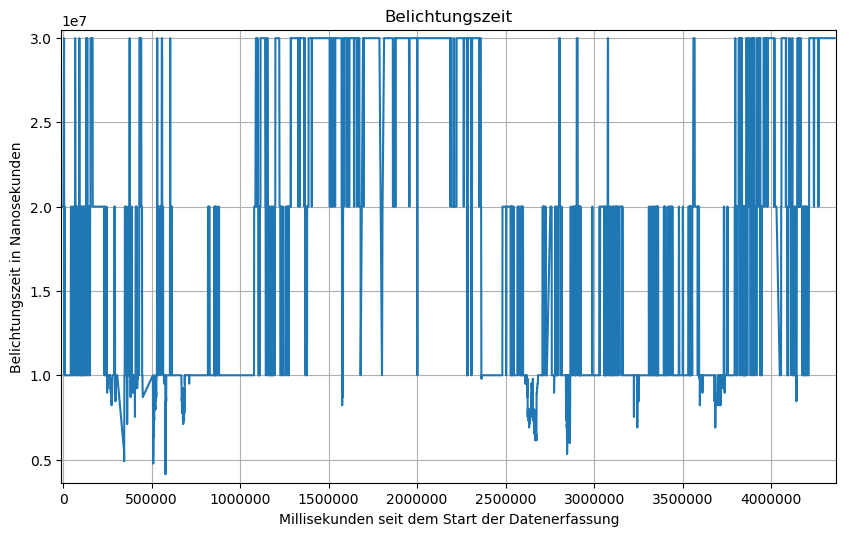

In [10]:
fig = plt.figure(num=None, figsize=(10, 6), dpi=100)
plt.title('Belichtungszeit')
plt.ylabel('Belichtungszeit in Nanosekunden')
plt.xlabel('Millisekunden seit dem Start der Datenerfassung')
plt.plot(featuresDf['Millisekunden'],featuresDf['Belichtungszeit'])
xOffset = 10000 # Für schönen Plot
yOffset = 500000 
plt.grid(True)
plt.xlim(-xOffset, featuresDf.iloc[-1,:].Millisekunden+xOffset)
plt.ylim(featuresDf.Belichtungszeit.min()-yOffset, featuresDf.Belichtungszeit.max()+yOffset)
plt.savefig("belichtungszeit.jpg")

In [11]:
startSensorDataCollectionDf = featuresDf.StartBewegungsD
startExposureDf = featuresDf.StartBelichtung

Die Funktion berechnet den Mittelwert der Differenz zwischen zwei Dataframes mit einer Spalte.   
Prec.: startDf und endDf haben jeweils eine Spalte. Anzahl der Reihen der Dataframes > 0   
Postc: Gibt den Mittelwert zurück   

In [12]:
def calcMeanTime(startDf,endDf):
    meanStartM = startDf.iloc[:].mean()
    meanStartE = endDf.iloc[:].mean()
    return meanStartM - meanStartE

In [13]:
calcMeanTime(startExposureDf,startSensorDataCollectionDf)

89665827.70410156

Berechnitt die maximale Differenz zwischen den Achsen von zwei Dataframes   
Prec.: startDf und endDf haben jeweils eine Spalte. Anzahl der Reihen der Dataframes > 0     
Postc.: Maximaler Wert

In [14]:
def calcMaxGap(endDf,startDf):
    maxDf = endDf - startDf
    return maxDf.max()

Berechnitt die minimale Differenz zwischen den Achsen von zwei Dataframes   
Prec.: startDf und endDf haben jeweils eine Spalte. Anzahl der Reihen der Dataframes > 0     
Postc.: Minimaler Wert

In [15]:
def calcMinGap(endDf,startDf):
    maxDf = endDf - startDf
    return maxDf.min()

In [16]:
calcMaxGap(startExposureDf, startSensorDataCollectionDf)

142471329

In [17]:
calcMinGap(startExposureDf, startSensorDataCollectionDf)

45299031

In [18]:
# Dataframe mit Startpunkten der Belichtungszeit einer Aufnahme addiert mit der jeweiligen Belichtungszeit
startExposurePlusExposureTime = featuresDf.StartBelichtung + featuresDf.Belichtungszeit
startExposurePlusExposureTime.head(2)

0    1618578573379
1    1619346924379
dtype: int64

In [19]:
# Mitteltert der belichtungszeit
featuresDf.Belichtungszeit.mean()

19314396.80706231

In [20]:
# Max Belichtungszeit
featuresDf.Belichtungszeit.max()

29996324

In [21]:
# Minimale Belichtungszeit
featuresDf.Belichtungszeit.min()

4127597

In [23]:
# Berechnet den Mittelwert der Differenzen zwischen Start der Belichtungszeit mit 
# Belichtungszeit und Stopp der Bewesungssensordatenerfassung
# Warnung funktioniert nur wenn der DataFrame die Spalte StoppBewegungsD hat
calcMeanTime(startExposurePlusExposureTime,featuresDf.StoppBewegungsD)

AttributeError: 'DataFrame' object has no attribute 'StoppBewegungsD'

In [24]:
# Gibt den Index zurück mit der Zeitdifferenz größer als der angegebene Grenzwert
diffDf = startExposurePlusExposureTime - featuresDf.StoppBewegungsD
diffDf[diffDf > 5000000000]
featuresDf.iloc[3709]

AttributeError: 'DataFrame' object has no attribute 'StoppBewegungsD'

In [26]:
diffDf.min()

NameError: name 'diffDf' is not defined

In [27]:
# Warnung funktioniert nur wenn der DataFrame die Spalte StoppBewegungsD hat
calcMaxGap(startExposurePlusExposureTime, featuresDf.StoppBewegungsD)

AttributeError: 'DataFrame' object has no attribute 'StoppBewegungsD'

In [29]:
# Unittests
import unittest

class CalcTimeframeTest(unittest.TestCase):
    
    # Testet die Funktion calcMaxGap
    # Dabei wird mehrere Datenwerte verwendet
    def testCalcMaxGap(self):
        dEnd = [10, 20, 5]
        dfEnd = pandas.DataFrame(dEnd)
        dStart = [2, 10, 1]
        dfStart = pandas.DataFrame(dStart)
        self.assertEqual(calcMaxGap(dfEnd,dfStart)[0], 10)
        
    # Testet die Funktion calcMaxGap
    # Dabei wird ein Datenwert genutzt
    def testCalcMaxGapOne(self):
        dEnd = [10]
        dfEnd = pandas.DataFrame(dEnd)
        dStart = [10]
        dfStart = pandas.DataFrame(dStart)
        self.assertEqual(calcMaxGap(dfEnd,dfStart)[0], 0)
        
    # Testet die Funktion calcMinGap
    # Dabei wird mehrere Datenwerte verwendet
    def testCalcMinGap(self):
        dEnd = [10, 20, 5]
        dfEnd = pandas.DataFrame(dEnd)
        dStart = [2, 10, 1]
        dfStart = pandas.DataFrame(dStart)
        self.assertEqual(calcMinGap(dfEnd,dfStart)[0], 4)
        
    # Testet die Funktion calcMaxGap
    # Die Anzahl der Reihen ist unterschiedlich
    def testCalcMaxGapUnequal(self):
        dEnd = [10,20,20]
        dfEnd = pandas.DataFrame(dEnd)
        dStart = [10]
        dfStart = pandas.DataFrame(dStart)
        self.assertEqual(calcMaxGap(dfEnd,dfStart)[0], 0)
        
    # Dieser Test testet die Funktion calcMeanTime.
    # Hier wird die Mittlere Differenz gleich 0 erwartet
    def testCalcMeanTimeZero(self):
        dEnd = [10,10,10]
        dfEnd = pandas.DataFrame(dEnd)
        dStart = [10,10,10]
        dfStart = pandas.DataFrame(dStart)
        self.assertEqual(calcMeanTime(dfEnd,dfStart)[0], 0.0)
        
    # Dieser Test testet die Funktion calcMeanTime.
    # Hier wird die Mittlere Differenz gleich 0 erwartet
    def testCalcMeanTimeZero(self):
        dEnd = [10,10,10]
        dfEnd = pandas.DataFrame(dEnd)
        dStart = [10,10,10]
        dfStart = pandas.DataFrame(dStart)
        self.assertEqual(calcMeanTime(dfEnd,dfStart)[0], 0.0)
    
    # Test die Funktion calcMeanTime.
    # Es werden mehrere unterschiedliche Werte getestet
    def testCalcMeanTimeValues(self):
        dEnd = [4,8,3,5,60]
        dfEnd = pandas.DataFrame(dEnd)
        dStart = [4,3,10,40,3]
        dfStart = pandas.DataFrame(dStart)
        self.assertEqual(calcMeanTime(dfEnd,dfStart)[0], 4.0)        
  
    # Test die Funktion calcMeanTime.
    # Dabei sind die Anzahl der Reihen unterschiedlich
    def testCalcMeanTimeUnequal(self):
        dEnd = [4,8,3,5,60]
        dfEnd = pandas.DataFrame(dEnd)
        dStart = [4,6,10,40]
        dfStart = pandas.DataFrame(dStart)
        self.assertEqual(calcMeanTime(dfEnd,dfStart)[0], 1.0)        

unittest.main(argv=[''], verbosity=2, exit=False)

testCalcMaxGap (__main__.CalcTimeframeTest) ... ok
testCalcMaxGapOne (__main__.CalcTimeframeTest) ... ok
testCalcMaxGapUnequal (__main__.CalcTimeframeTest) ... ok
testCalcMeanTimeUnequal (__main__.CalcTimeframeTest) ... ok
testCalcMeanTimeValues (__main__.CalcTimeframeTest) ... ok
testCalcMeanTimeZero (__main__.CalcTimeframeTest) ... ok
testCalcMinGap (__main__.CalcTimeframeTest) ... ok

----------------------------------------------------------------------
Ran 7 tests in 0.031s

OK
